In [ ]:
# STEP 1 : Loading  the data

import pandas as pd
import numpy as np
import os

csv_path = r"C:\Users\Lenovo\Downloads\Subject_masterdata.csv"
signal_dir = r"C:\Users\Lenovo\Downloads\SaveRedData-20250611T102321Z-1-001\SaveRedData"

# Load the master CSV
master_df = pd.read_csv(csv_path)
print("Master CSV loaded:")
print(master_df.head())

# Print column names to ensure you reference the correct one
print("\nCSV Columns:", master_df.columns.tolist())

# Assuming 'Subject_ID' contains values like 'Sub1', 'Sub2'...
file_column = 'Subject_ID'

# Load signal data
signal_data = {}
for idx, row in master_df.iterrows():
    file_name = row[file_column] + ".txt"
    file_path = os.path.join(signal_dir, file_name)
    
    try:
        signal = np.loadtxt(file_path)
        signal_data[file_name] = signal
    except Exception as e:
        print(f"Error loading {file_name}: {e}")


sample_file = master_df[file_column].iloc[0] + ".txt"
print(f"\nFirst 10 signal values from {sample_file}:")
print(signal_data[sample_file][:10])


Master CSV loaded:
  Subject_ID  Age Gender  Height  Weight  Pulse  SpO2  SBP  DBP  \
0       Sub1   23      M     180      98     82    98  128   71   
1       Sub2   20      M     167      69     77    98  135   91   
2       Sub3   21      M     190      90     82    98  125   81   
3       Sub4   20      F     157      47    100    98  125   78   
4       Sub5   21      M     175      75     75    98  121   66   

                 Diet  
0  Fasting since 2hrs  
1  Fasting since 2hrs  
2  Fasting since 2hrs  
3  Fasting since 2hrs  
4  Fasting since 2hrs  

CSV Columns: ['Subject_ID', 'Age', 'Gender', 'Height', 'Weight', 'Pulse', 'SpO2', 'SBP', 'DBP', 'Diet']

First 10 signal values from Sub1.txt:
[  0.58164352   0.86405093   3.32208333  10.59386574  36.05385417
  97.32601852 179.17084201 186.11597801 187.80374711 187.95427662]


In [ ]:
# STEP 2 : Preprocessing the signal data

def preprocess_signal(signal, window_size=5):
   
    signal = signal[np.nonzero(signal)]  # remove zeros from start
    if signal.size == 0:
        return np.zeros(100)  # fallback if empty
    
    # Step 2: Apply moving average smoothing
    smoothed = np.convolve(signal, np.ones(window_size)/window_size, mode='valid')
    
    return smoothed


In [18]:
# Dictionary to store preprocessed signals
preprocessed_signals = {}

for file_name, signal in signal_data.items():
    processed = preprocess_signal(signal)
    preprocessed_signals[file_name] = processed

# Show example
sample_file = list(preprocessed_signals.keys())[0]
print(f"\nPreprocessed signal sample from {sample_file}:")
print(preprocessed_signals[sample_file][:10])



Preprocessed signal sample from Sub1.txt:
[ 10.28309954  29.63197454  65.29333275 101.85211169 137.29408796
 167.67417245 185.73277604 187.66082523 188.0239537  187.74588657]


In [ ]:
# STEP 3 : Normalizing the signal data

def normalize_signal(signal):
    """
    Normalizes the signal to the range [0, 1] using min-max normalization.
    """
    min_val = np.min(signal)
    max_val = np.max(signal)
    
    # Prevent division by zero
    if max_val == min_val:
        return np.zeros_like(signal)
    
    normalized = (signal - min_val) / (max_val - min_val)
    return normalized


In [20]:
# Dictionary to store normalized signals
normalized_signals = {}

for file_name, signal in preprocessed_signals.items():
    norm_signal = normalize_signal(signal)
    normalized_signals[file_name] = norm_signal

# Show sample
sample_file = list(normalized_signals.keys())[0]
print(f"\nNormalized signal sample from {sample_file}:")
print(normalized_signals[sample_file][:10])



Normalized signal sample from Sub1.txt:
[0.         0.1070627  0.3043869  0.50667678 0.70278708 0.87088853
 0.9708118  0.98148023 0.98348952 0.9819509 ]


In [ ]:
# STEP 4  : Feature Extraction

from scipy.stats import skew, kurtosis

def extract_features(signal):
    """
    Extracts statistical features from a normalized signal.
    Returns a feature vector (list).
    """
    features = {
        'mean': np.mean(signal),
        'std': np.std(signal),
        'max': np.max(signal),
        'min': np.min(signal),
        'energy': np.sum(signal**2),
        'rms': np.sqrt(np.mean(signal**2)),
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal)
    }
    return features


In [22]:
# List to store feature dicts
feature_list = []

# Corresponding labels (HR, SBP, DBP)
labels = []

for idx, row in master_df.iterrows():
    subject_id = row['Subject_ID']
    file_name = subject_id + ".txt"

    if file_name in normalized_signals:
        signal = normalized_signals[file_name]
        features = extract_features(signal)
        feature_list.append(features)

        # Target values
        labels.append({
            'HR': row['Pulse'],
            'SBP': row['SBP'],
            'DBP': row['DBP']
        })

# Convert to DataFrame
X = pd.DataFrame(feature_list)
y = pd.DataFrame(labels)

# Show extracted features
print("\nFeature sample:")
print(X.head())
print("\nTarget values sample:")
print(y.head())



Feature sample:
       mean       std  max  min       energy       rms   skewness    kurtosis
0  0.932558  0.035450  1.0  0.0  2086.728654  0.933232 -15.969738  370.391639
1  0.174469  0.078531  1.0  0.0    87.709007  0.191328   0.353396    5.782643
2  0.048663  0.038211  1.0  0.0     9.172287  0.061872  13.552842  262.761018
3  0.072715  0.047090  1.0  0.0    17.981596  0.086630   7.824347  130.128580
4  0.854079  0.069242  1.0  0.0  1759.250770  0.856881  -1.255479   10.648935

Target values sample:
    HR  SBP  DBP
0   82  128   71
1   77  135   91
2   82  125   81
3  100  125   78
4   75  121   66


In [ ]:
# STEP 5 : Correlation Analysis

combined_df = pd.concat([X, y], axis=1)

# Correlation matrix
corr_matrix = combined_df.corr(numeric_only=True)

# Display correlation of features with each target
print("Correlation with Heart Rate (HR):")
print(corr_matrix['HR'].sort_values(ascending=False))

print("\nCorrelation with SBP:")
print(corr_matrix['SBP'].sort_values(ascending=False))

print("\nCorrelation with DBP:")
print(corr_matrix['DBP'].sort_values(ascending=False))


Correlation with Heart Rate (HR):
HR          1.000000
skewness    0.319248
DBP         0.166642
SBP         0.119278
std         0.105813
rms        -0.299179
mean       -0.300450
energy     -0.336560
kurtosis   -0.422435
max              NaN
min              NaN
Name: HR, dtype: float64

Correlation with SBP:
SBP         1.000000
DBP         0.813633
skewness    0.403285
std         0.396585
HR          0.119278
rms        -0.253937
mean       -0.261691
energy     -0.280391
kurtosis   -0.490360
max              NaN
min              NaN
Name: SBP, dtype: float64

Correlation with DBP:
DBP         1.000000
SBP         0.813633
std         0.379835
skewness    0.326057
HR          0.166642
rms        -0.153934
mean       -0.162745
energy     -0.176816
kurtosis   -0.393707
max              NaN
min              NaN
Name: DBP, dtype: float64


In [24]:
# Drop 'max' and 'min' from the feature set
X_selected = X.drop(columns=['max', 'min'])

print("Final selected features:")
print(X_selected.columns.tolist())


Final selected features:
['mean', 'std', 'energy', 'rms', 'skewness', 'kurtosis']


In [ ]:
# STEP 6 : Model Training and Evaluation

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [47]:
# Split data: train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store models and predictions
models = {}
predictions = {}
metrics = {}

# Loop through each target
for target in ['HR', 'SBP', 'DBP']:
    print(f"\n🔹 Training model for {target}...")
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train[target])
    
    y_pred = model.predict(X_test)
    
    # Store
    models[target] = model
    predictions[target] = y_pred
    metrics[target] = {
        'MAE': mean_absolute_error(y_test[target], y_pred),
        'R2 Score': r2_score(y_test[target], y_pred)
    }
    
    print(f" {target} - MAE: {metrics[target]['MAE']:.2f}, R²: {metrics[target]['R2 Score']:.2f}")



🔹 Training model for HR...
 HR - MAE: 12.38, R²: -0.01

🔹 Training model for SBP...
 SBP - MAE: 27.42, R²: -1.15

🔹 Training model for DBP...
 DBP - MAE: 14.58, R²: -0.47


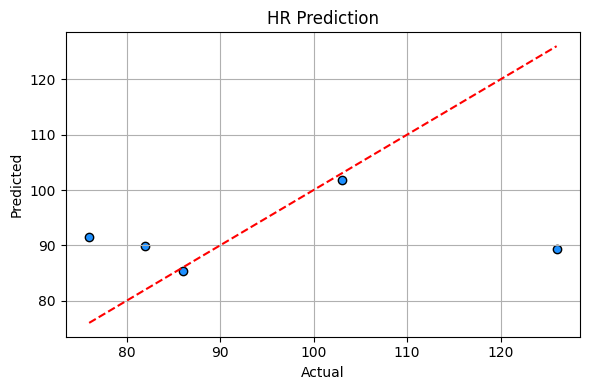

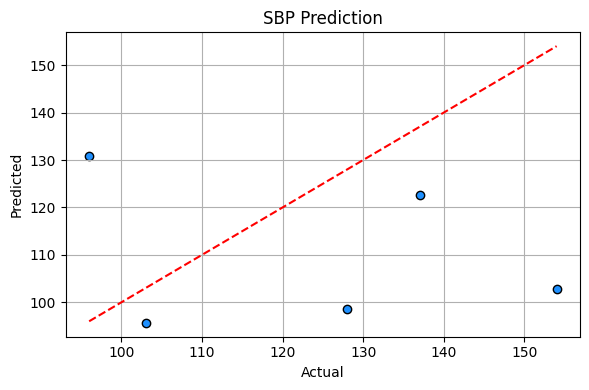

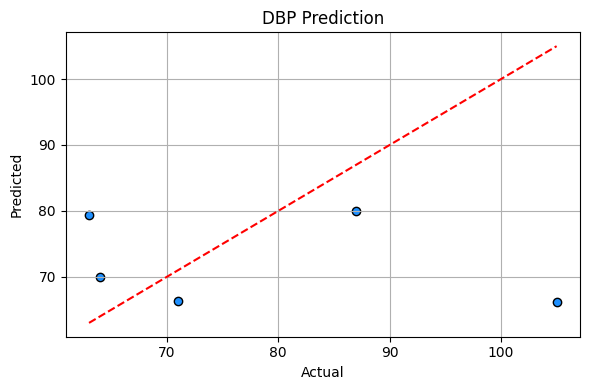

In [ ]:
# STEP 7 : Visualizing Predictions
import matplotlib.pyplot as plt

# Plot predictions vs actuals
def plot_predictions(y_true, y_pred, target):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, color='dodgerblue', edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{target} Prediction")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Apply for each target
for target in ['HR', 'SBP', 'DBP']:
    plot_predictions(y_test[target], predictions[target], target)


In [48]:
# STEP 8 : Making Predictions on Unseen Data
new_files = [
    r"C:\Users\Lenovo\Downloads\Sub1.txt",
    r"C:\Users\Lenovo\Downloads\Sub2.txt",
]

for file_path in new_files:
    try:
        # Load
        signal = np.loadtxt(file_path)
        
        # Preprocess → Normalize → Feature extraction
        processed = preprocess_signal(signal)
        normalized = normalize_signal(processed)
        features = extract_features(normalized)
        
        # Convert to DataFrame (1 row)
        X_new = pd.DataFrame([features])
        
        # Predict
        print(f"\n📄 Predictions for unseen data  {os.path.basename(file_path)}:")
        for target in ['HR', 'SBP', 'DBP']:
            pred = models[target].predict(X_new)[0]
            print(f"  {target}: {pred:.2f}")
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")



📄 Predictions for unseen data  Sub1.txt:
  HR: 89.87
  SBP: 98.50
  DBP: 66.32

📄 Predictions for unseen data  Sub2.txt:
  HR: 86.79
  SBP: 134.32
  DBP: 86.64
